In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE_TRAINING = 100
IMAGE_RESIZE = (240, 320)

train_data_generator = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_data_generator.flow_from_directory(
    'S:\Academic\Final Year Project\crime-detection\Frames', 
    target_size=IMAGE_RESIZE, 
    batch_size=BATCH_SIZE_TRAINING, 
    class_mode='binary'
)

Found 8394 images belonging to 2 classes.


In [3]:
print(f'train_gen.class_indices: {train_generator.class_indices}')

train_gen.class_indices: {'Crime': 0, 'Normal': 1}


In [4]:
division = {1:4034, 0:7379}
length = 11413

def balancedClassWeight(n_samples: int, n_samples_with_class: dict) -> dict:
    
    toRet = {}
    n_classes=len(n_samples_with_class.keys())
    
    keys = n_samples_with_class.keys()
    
    for item in keys:
        toRet[item] = (n_samples/(n_classes*n_samples_with_class[item]))
        
    return toRet

class_weight = balancedClassWeight(length, division)

print(f'class weights: {class_weight}')

class weights: {1: 1.4146008924144768, 0: 0.7733432714459954}


In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model


baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(240, 320, 3)))
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)


for layer in baseModel.layers:
    layer.trainable = False

In [6]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(lr=1e-4)
model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])


from tensorflow.python.keras.callbacks import EarlyStopping
cb_early_stopper = EarlyStopping(monitor = 'loss', patience = 4)

In [7]:
NUM_EPOCHS = 10
STEPS_PER_EPOCH_TRAINING = 100

fit_history = model.fit_generator(
    train_generator,

    class_weight=class_weight,
    epochs = NUM_EPOCHS,
    callbacks=[cb_early_stopper]
)

Epoch 1/10
84/84 [==============================] - 11641s 140s/step - loss: 0.2429 - accuracy: 0.9120
Epoch 2/10
84/84 [==============================] - 6670s 80s/step - loss: 0.0345 - accuracy: 0.9871
Epoch 3/10
84/84 [==============================] - 967s 11s/step - loss: 0.0107 - accuracy: 0.9963
Epoch 4/10
84/84 [==============================] - 926s 11s/step - loss: 0.0091 - accuracy: 0.9961
Epoch 5/10
84/84 [==============================] - 838s 10s/step - loss: 0.0104 - accuracy: 0.9956
Epoch 6/10
84/84 [==============================] - 659s 8s/step - loss: 0.0072 - accuracy: 0.9980
Epoch 7/10
84/84 [==============================] - 660s 8s/step - loss: 0.0049 - accuracy: 0.9980
Epoch 8/10
84/84 [==============================] - 654s 8s/step - loss: 0.0098 - accuracy: 0.9963
Epoch 9/10
84/84 [==============================] - 657s 8s/step - loss: 0.0105 - accuracy: 0.9968
Epoch 10/10
84/84 [==============================] - 654s 8s/step - loss: 0.0045 - accuracy: 0.9985


In [8]:
model_save_path = 'model_x-y-21.h5'
model.save(model_save_path)

In [9]:
print(fit_history.history.keys())

dict_keys(['loss', 'accuracy'])


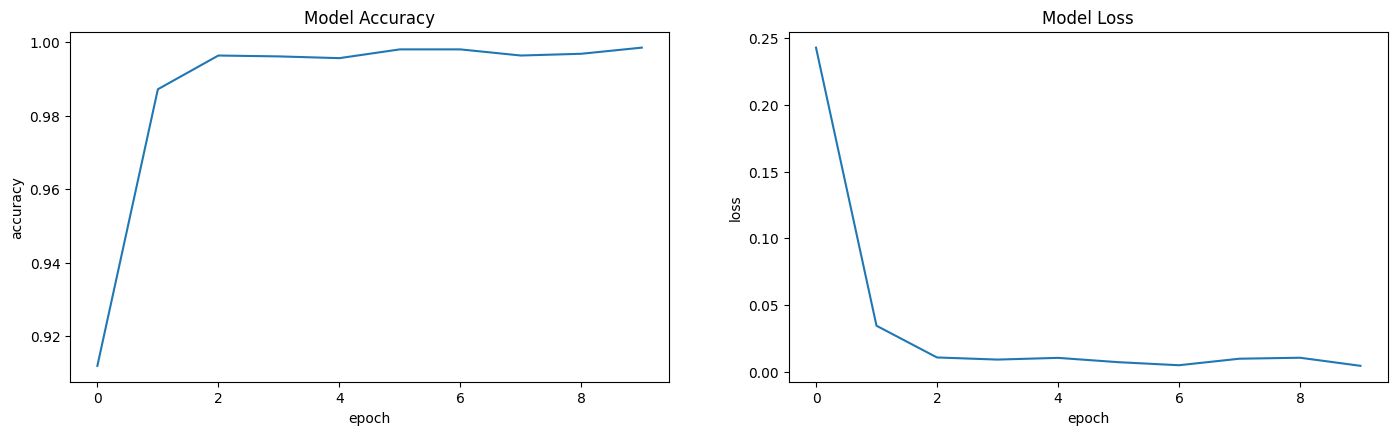

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(1, figsize = (17,10))
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])    
plt.title('Model Accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.title('Model Loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.show()